## Laporan Proyek _Machine Leraning_ - Fikri Septrian Anggara

### Import library yang diperlukan

In [1]:
# pengolahan data
import pandas as pd
import numpy as np

# visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# pembangunan klaster
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors

# scaling data
from sklearn.preprocessing import MinMaxScaler

# imputasi data
from sklearn.impute import SimpleImputer

# reduksi dimensi
from sklearn.decomposition import PCA

# evaluasi klaster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# disable warning
import warnings
warnings.simplefilter(action='ignore')

# 2. Data Understanding

### 2.1. Menyiapkan Dataset
dataset diperoleh dari kaggle, terdapat dua dataset yang digunakan yaitu:
 - [financial statement idx stocks](https://www.kaggle.com/datasets/greegtitan/financial-statement-idx-stocks?resource=download) (kaggle). terakhir diupdate pada Oktober 2022.
 - [daftar saham](https://www.kaggle.com/datasets/muamkh/ihsgstockdata?select=DaftarSaham.csv) (kaggle). terakhir diupdate pada Januari 2023

load data

In [2]:
stockQuarter = pd.read_csv('../data/quarter.csv')
masterStock = pd.read_csv('../data/DaftarSaham.csv')

### 2.2. Overview Data
pada tahap ini dilakukan _overview_ pada data stockQuarter dan masterStock

banyaknya baris dan kolom (baris, kolom)

In [3]:

print(stockQuarter.shape)
print(masterStock.shape)

(208691, 8)
(829, 14)


kolom dan tipe data

In [193]:
stockQuarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208691 entries, 0 to 208690
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   symbol        208691 non-null  object 
 1   account       208691 non-null  object 
 2   type          208149 non-null  object 
 3   2021-09-30    51722 non-null   float64
 4   2021-12-31    51538 non-null   float64
 5   2022-03-31    53449 non-null   float64
 6   2022-06-30    50375 non-null   float64
 7   2022-09-30    17013 non-null   float64
 8   account_type  208149 non-null  object 
dtypes: float64(5), object(4)
memory usage: 14.3+ MB


kolom dan tipe data

In [5]:
masterStock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Code                829 non-null    object 
 1   Name                829 non-null    object 
 2   ListingDate         829 non-null    object 
 3   Shares              829 non-null    float64
 4   ListingBoard        829 non-null    object 
 5   Sector              829 non-null    object 
 6   LastPrice           824 non-null    float64
 7   MarketCap           824 non-null    float64
 8   MinutesFirstAdded   787 non-null    object 
 9   MinutesLastUpdated  787 non-null    object 
 10  HourlyFirstAdded    806 non-null    object 
 11  HourlyLastUpdated   806 non-null    object 
 12  DailyFirstAdded     824 non-null    object 
 13  DailyLastUpdated    824 non-null    object 
dtypes: float64(3), object(11)
memory usage: 90.8+ KB


ambil sampel random sebanyak 5 data

In [6]:
stockQuarter.sample(n=5, random_state=1)


,symbol,account,type,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30
181194,SQMI,CF,Cash From Discontinued Investing Activities,NaN,NaN,NaN,NaN,NaN
137781,MSKY,CF,Paymentson Behalfof Employees,-8.421300e+10,-7.747800e+10,-6.249900e+10,-6.643200e+10,NaN
22706,BBHI,BS,Long Term Debt And Capital Lease Obligation,4.114605e+09,3.291684e+09,0.000000e+00,4.575037e+10,4.135613e+10
143195,NETV,IS,Credit Card,NaN,NaN,NaN,NaN,NaN
184286,SUPR,BS,Securities And Investments,NaN,NaN,NaN,NaN,NaN


jumlah null tiap kolom

In [7]:
stockQuarter.isnull().sum()

symbol             0
account            0
type             542
2021-09-30    156969
2021-12-31    157153
2022-03-31    155242
2022-06-30    158316
2022-09-30    191678
dtype: int64

- terdapat banyak ****null value**** pada data saham perkuarter

ambil sampel random sebanyak 5 data

In [8]:
masterStock.sample(n=5, random_state=1)

,Code,Name,ListingDate,Shares,ListingBoard,Sector,LastPrice,MarketCap,MinutesFirstAdded,MinutesLastUpdated,HourlyFirstAdded,HourlyLastUpdated,DailyFirstAdded,DailyLastUpdated
370,INTA,Intraco Penta Tbk.,1993-08-23,3.343935e+09,Pengembangan,Industrials,74.0,2.474512e+11,2021-11-01 09:00:00,2022-06-03 15:59:00,2020-04-16 09:00:00,2022-06-03 16:00:00,2001-04-16,2023-01-06
449,LION,Lion Metal Works Tbk.,1993-08-20,5.201600e+08,Utama,Industrials,735.0,3.823176e+11,2021-11-01 09:00:00,2023-01-06 15:59:00,2020-04-16 09:00:00,2023-01-06 15:00:00,2001-04-16,2023-01-06
810,WINR,Winner Nusantara Jaya Tbk.,2022-04-25,5.235200e+09,Utama,Properties & Real Estate,50.0,2.617600e+11,2022-04-25 09:00:00,2023-01-06 15:59:00,2022-04-25 09:00:00,2023-01-06 15:00:00,2022-04-25,2023-01-06
578,PDPP,Primadaya Plastisindo Tbk.,2022-11-09 00:00:00,2.500000e+09,Pengembangan,Basic Materials,202.0,5.050000e+11,2022-11-09 09:00:00,2023-01-06 15:59:00,2022-11-09 09:00:00,2023-01-06 15:00:00,2022-11-10,2023-01-06
700,SMRU,SMR Utama Tbk.,2011-10-10,1.249939e+10,Pengembangan,Energy,50.0,6.249693e+11,NaN,NaN,NaN,NaN,2011-10-10,2023-01-06


5 number summary stock quarter

In [9]:
# 5 number summary stock quarter
stockQuarter.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
symbol,208691,544,AALI,391,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account,208691,3,BS,73461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,208149,388,Interest Received,1080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,51722.0,NaN,NaN,NaN,1918202605901.322021,24798786684018.976562,-175313000000000.0,0.0,5837091260.0,233651664187.5,1637950171000000.0
2021-12-31,51538.0,NaN,NaN,NaN,2042450921973.788574,26106014954333.765625,-438813037000000.0,0.0,7402772575.0,257243562462.0,1725611128000000.0
2022-03-31,53449.0,NaN,NaN,NaN,1940242135220.246094,25585023607145.355469,-223695701000000.0,0.0,5526650874.0,214030861495.0,1734074740000000.0
2022-06-30,50375.0,NaN,NaN,NaN,2139261720062.068848,26835599887835.515625,-194169000000000.0,0.0,7726820540.0,265889690000.0,1785706841000000.0
2022-09-30,17013.0,NaN,NaN,NaN,3359261415683.166504,33720778198892.175781,-197134246000000.0,79886.0,20220521000.0,557420000000.0,1839336498000000.0


- terdapat **544** buah saham
- terdapat **388** variabel pada laporan keuangan
- terdapat **3** kategori akun yaitu balance sheet, cash-flow dan income statement

5 number summary master stock

In [10]:
# 5 number summary master stock
masterStock.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Code,829,829,AALI,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,829,829,Astra Agro Lestari Tbk.,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ListingDate,829,713,2022-11-08 00:00:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shares,829.0,NaN,NaN,NaN,10946944360.291918,45395931792.267258,3600000.0,1230839821.0,3128090000.0,9327465018.0,1184363929502.0
ListingBoard,829,3,Pengembangan,422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sector,829,11,Consumer Cyclicals,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LastPrice,824.0,NaN,NaN,NaN,1363.453883,3733.432446,25.0,101.75,287.0,975.0,38000.0
MarketCap,824.0,NaN,NaN,NaN,10076631834955.722656,50531421356601.734375,9000000000.0,297528301025.0,1111304868160.0,4236952973400.0,1012951085850000.0
MinutesFirstAdded,787,60,2021-11-01 09:00:00,698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MinutesLastUpdated,787,18,2023-01-06 15:59:00,759,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Terdapat 11 sektor pada master stok dengan **Consumer Cyclicals** adalah sektor yang paling banyak emitennya
- Terdapat 829 buah emiten

variabel pada laporan keuangan

In [11]:
# variabel pada laporan keuangan
pd.DataFrame(pd.unique(stockQuarter['type']))

,0
0,Long Term Equity Investment
1,Additional Paid In Capital
2,Long Term Debt
3,Ordinary Shares Number
4,Total Assets
...,...
384,Interest Income From Deposits
385,Credit Losses Provision
386,Other Interest Income
387,Interest Expense For Federal Funds Sold And Se...


_dataframe_ **stockQuarter** memiliki 208691 baris dan 8 kolom. ke delapan kolom yaitu :
 - **symbol**: Kode saham IDX seperti BBRI, BBCA, BMRI, dst.
 - **account**: Akun laporan keuangan. nilainya meliputi **BS** untuk _Balance Sheet_, **IS** untuk akun _Income Statement_, dan **CF** untuk akun _Cash Flow_.
 - **type**: Tipe/variabel laporan keuangan seperti data total aset, kredit, dividen yang dibayarkan, dst. memiliki 388 tipe.
 - Kolom data variabel laporan keuangan perkuarter. meliputi tanggal **2021-09-30**, **2021-12-31**, **2022-03-31**, **2022-06-30**, **2022-09-30**.
 
_dataframe_ **masterStock** memiliki 829 baris dan 14 kolom. ke empat belas kolom tersebut yaitu:
 - **Code**: Kode saham IDX
 - **Name**: Nama saham
 - **ListingDate**: Tanggal pendaftaran saham
 - **Shares**: Total saham beredar
 - **ListingBoard**: Tingkat pasar saham, meliputi tingkat akselerasi, pengembangan dan utama
 - **Sector**: Sektor perusahaan
 - **LastPrice**: Harga terakhir saham
 - **MarketCap**: Total nilai perusahaan
 - **MinutesFirstAdded**: Menit pertama data ditambahkan
 - **MinutesLastUpdated**: Menit terakhir data diperbarui
 - **HourlyFirstAdded**: Jam pertama data ditambahkan
 - **HourlyLastUpdated**: Jam terakhir data diperbarui
 - **DailyFirstAdded**: Tanggal Pertama data ditambahkan
 - **DailyLastUpdated**: Tanggal Terakhir data diperbarui

terdapat 389 variabel pada laporan keuangan

Berdasarkan _Overview Data_, diketahui :
- Terdapat banyak **null value** pada data saham perkuarter
- Terdapat **544** buah saham yang tercatat laporan keuangannya
- Terdapat **388** variabel pada laporan keuangan
- Terdapat **3** kategori akun yaitu balance sheet, cash-flow dan income statement
- Terdapat **11** sektor pada master stok dengan **Consumer Cyclicals** adalah sektor yang paling banyak emitennya
- Terdapat total **829** buah saham
- Terdapat **389** variabel pada laporan keuangan


# 3. Data Preparation

Data stockQuarter masih belum memiliki struktur yang bisa digunakan untuk pembuatan model dan belum digabung dengan masterStock untuk memperoleh data sektor. 
Maka pada ada tahap _Data Preparation_, penulis :
1. merubah struktur data stockQuarter agar cocok untuk pembangunan model klaster
2. menggabungkan data stockQuarter dan masterStock
3. melakukan feature engineering untuk memperoleh indikator fundamental yang digunakan pada paper Examining the effectiveness of fundamental analysis
in a long-term stock portfolio
4. melakukan feature selection
5. melakukan analisis data eksploratif
6. melakukan imputasi pada fitur
7. melakukan scaling

karena data stockQuarter terbaru (2022-09-30) memiliki paling banyak _null value_, maka penulis menggunakan data kuarter sebelumnya, yaitu data kuarter kedua tahun 2022.

buat kolom baru, gabungan antara account dan type untuk menyimpan nilai tipe akun

In [12]:
# buat kolom baru, gabungan antara account dan type untuk menyimpan nilai tipe akun
stockQuarter['account_type'] = stockQuarter['account']+'_'+stockQuarter['type']
stockQuarter.head()

,symbol,account,type,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,account_type
0,AALI,BS,Long Term Equity Investment,3.235200e+11,3.309040e+11,3.275800e+11,2.850690e+11,4.714630e+11,BS_Long Term Equity Investment
1,AALI,BS,Additional Paid In Capital,3.878995e+12,3.878995e+12,3.878995e+12,3.878995e+12,3.878995e+12,BS_Additional Paid In Capital
2,AALI,BS,Long Term Debt,5.709887e+12,2.131944e+12,2.144732e+12,2.220370e+12,3.281008e+12,BS_Long Term Debt
3,AALI,BS,Ordinary Shares Number,1.924688e+09,1.924688e+09,1.924688e+09,1.924688e+09,1.924688e+09,BS_Ordinary Shares Number
4,AALI,BS,Total Assets,2.969401e+13,3.039991e+13,3.123278e+13,3.023399e+13,3.263865e+13,BS_Total Assets


### 3.1 Mengubah Struktur Data

ambil data 2022 kuarter dua saja.<br>
reshaping data, kolom" data yang baru merupakan value dari 'type' dari df yang lama

In [13]:
# ambil data 2022 kuarter dua saja
data2022 = stockQuarter[['symbol', 'account_type', '2022-03-31']].copy()

# reshaping data, kolom" data yang baru merupakan value dari 'type' dari df yang lama
dataReshaped = pd.DataFrame(data2022.pivot_table(
    index='symbol',
    columns='account_type',
    values='2022-03-31'
).reset_index())
dataReshaped.sample(n=5, random_state=1)

account_type,symbol,BS_Accounts Payable,BS_Accounts Receivable,BS_Accumulated Depreciation,BS_Additional Paid In Capital,BS_Allowance For Doubtful Accounts Receivable,BS_Allowance For Loans And Lease Losses,BS_Assets Held For Sale,BS_Available For Sale Securities,BS_Buildings And Improvements,...,IS_Selling General And Administration,IS_Special Income Charges,IS_Tax Effect Of Unusual Items,IS_Tax Provision,IS_Tax Rate For Calcs,IS_Total Premiums Earned,IS_Total Revenue,IS_Total Unusual Items,IS_Total Unusual Items Excluding Goodwill,IS_Write Off
306,MDKA,4.401516e+07,8.253260e+05,-4.256159e+08,4.547795e+08,NaN,NaN,NaN,1.230013e+06,4.504931e+07,...,3.092272e+06,5.096306e+07,12082698.0,2.153781e+07,0.0,NaN,1.230877e+08,4.878026e+07,4.878026e+07,NaN
342,MYOH,1.228796e+07,1.208013e+07,-1.492356e+08,1.261815e+07,NaN,NaN,NaN,NaN,6.112533e+06,...,7.194650e+05,NaN,0.0,2.863380e+05,0.0,NaN,3.117401e+07,NaN,NaN,NaN
47,AVIA,6.746287e+11,1.057628e+12,-6.898225e+11,7.793218e+12,-473651231.0,NaN,NaN,NaN,4.669956e+11,...,1.062750e+11,1.221673e+09,-187918702.0,8.335560e+10,0.0,NaN,1.639030e+12,-1.056299e+09,-1.056299e+09,NaN
67,BCIC,4.062000e+10,NaN,-1.606550e+11,1.125357e+12,NaN,1.910790e+11,NaN,3.297131e+12,2.614400e+11,...,3.507300e+10,1.800000e+07,0.0,0.000000e+00,0.0,NaN,1.383500e+11,1.800000e+07,1.800000e+07,0.0
376,POWR,2.966666e+07,5.590051e+07,-8.802574e+08,1.478191e+08,-2389960.0,NaN,NaN,NaN,2.452767e+08,...,3.138509e+06,6.076500e+04,15326.0,8.027302e+06,0.0,NaN,1.323000e+08,6.076500e+04,6.076500e+04,NaN


saham yang tersedia

In [14]:
# saham yang tersedia
pd.DataFrame(pd.unique(dataReshaped['symbol']))

,0
0,AALI
1,ABBA
2,ABDA
3,ABMM
4,ACES
...,...
498,WSKT
499,WTON
500,YPAS
501,ZBRA


cek null value dari masing masing kolom

In [15]:
# cek null value dari masing masing kolom
nulltable = pd.DataFrame(dataReshaped.isnull().sum().reset_index().iloc[1:])
nulltable.columns = ['financial statement', 'sum of null']
print(nulltable)
print('total null: ', dataReshaped.isnull().sum().sum())

                               financial statement  sum of null
1                              BS_Accounts Payable           18
2                           BS_Accounts Receivable           73
3                      BS_Accumulated Depreciation            9
4                    BS_Additional Paid In Capital            5
5    BS_Allowance For Doubtful Accounts Receivable          163
..                                             ...          ...
222                       IS_Total Premiums Earned          480
223                               IS_Total Revenue            2
224                         IS_Total Unusual Items          163
225      IS_Total Unusual Items Excluding Goodwill          163
226                                   IS_Write Off          369

[226 rows x 2 columns]
total null:  60673


5 data teratas

In [16]:
# 5 data teratas
dataReshaped.head()

account_type,symbol,BS_Accounts Payable,BS_Accounts Receivable,BS_Accumulated Depreciation,BS_Additional Paid In Capital,BS_Allowance For Doubtful Accounts Receivable,BS_Allowance For Loans And Lease Losses,BS_Assets Held For Sale,BS_Available For Sale Securities,BS_Buildings And Improvements,...,IS_Selling General And Administration,IS_Special Income Charges,IS_Tax Effect Of Unusual Items,IS_Tax Provision,IS_Tax Rate For Calcs,IS_Total Premiums Earned,IS_Total Revenue,IS_Total Unusual Items,IS_Total Unusual Items Excluding Goodwill,IS_Write Off
0,AALI,1.142178e+12,4.200380e+11,-1.245127e+13,3.878995e+12,-2.468000e+10,NaN,NaN,NaN,4.868210e+12,...,1.809060e+11,3.315000e+09,9.493402e+08,2.029380e+11,0.0,NaN,6.581321e+12,3.315000e+09,3.315000e+09,NaN
1,ABBA,5.362099e+10,2.914954e+10,-1.598063e+11,-4.625487e+10,-6.362753e+10,NaN,NaN,2.631706e+11,2.381562e+10,...,4.395922e+09,0.000000e+00,0.000000e+00,2.868976e+08,0.0,NaN,2.558564e+10,0.000000e+00,0.000000e+00,0.0
2,ABDA,9.509586e+09,9.269251e+10,-1.022669e+11,8.109426e+09,NaN,NaN,NaN,-2.732850e+09,9.058304e+10,...,3.312257e+10,7.815000e+07,1.229908e+07,1.035408e+10,0.0,1.942160e+11,2.249341e+11,7.815000e+07,7.815000e+07,NaN
3,ABMM,1.350441e+08,1.781135e+08,-7.201580e+08,1.150872e+08,-9.259643e+06,NaN,NaN,2.346308e+07,9.113807e+07,...,1.018068e+07,NaN,0.000000e+00,1.919292e+07,0.0,NaN,2.867016e+08,NaN,NaN,NaN
4,ACES,1.489605e+11,9.819892e+10,-1.912185e+12,4.405749e+11,0.000000e+00,NaN,NaN,NaN,2.349405e+12,...,1.811643e+11,5.954735e+09,1.011450e+09,3.195468e+10,0.0,NaN,1.626507e+12,5.954735e+09,5.954735e+09,-333491240.0


### 3.2. Menggabungkan Data 

filter terlebih dahulu master data, rename kolom `symbol` menjadi `Code`, join data berdasarkan kolom `Code`

In [17]:
# filter kolom master data
filteredMasterStock = masterStock[['Code', 'Name', 'Shares', 'Sector', 'LastPrice']]

# ubah nama kolom agar bisa dijoin
renamedData = dataReshaped.rename(columns={'symbol':'Code'})

# join data stockQuarter dan masterStock
joinedData = pd.merge(left=renamedData, right=filteredMasterStock, on='Code', how='left')

5 data sampel hasil join

In [18]:
joinedData.sample(5)

,Code,BS_Accounts Payable,BS_Accounts Receivable,BS_Accumulated Depreciation,BS_Additional Paid In Capital,BS_Allowance For Doubtful Accounts Receivable,BS_Allowance For Loans And Lease Losses,BS_Assets Held For Sale,BS_Available For Sale Securities,BS_Buildings And Improvements,...,IS_Tax Rate For Calcs,IS_Total Premiums Earned,IS_Total Revenue,IS_Total Unusual Items,IS_Total Unusual Items Excluding Goodwill,IS_Write Off,Name,Shares,Sector,LastPrice
494,WMUU,1.298230e+11,1.470249e+11,-1.021586e+11,2.439882e+11,-1.075043e+09,NaN,NaN,NaN,4.121377e+11,...,0.0,NaN,6.304541e+11,1.855243e+09,1.855243e+09,NaN,Widodo Makmur Unggas Tbk.,1.294118e+10,Consumer Non-Cyclicals,62.0
168,DYAN,7.387966e+10,1.493628e+11,-5.696890e+11,2.592482e+11,-3.287327e+09,NaN,NaN,NaN,9.222731e+11,...,0.0,NaN,1.082672e+11,0.000000e+00,0.000000e+00,0.0,Dyandra Media International Tb,4.272964e+09,Industrials,90.0
72,BEST,2.056693e+10,2.809402e+11,-8.052994e+10,2.311536e+11,-3.095368e+09,NaN,NaN,9.607230e+10,1.512978e+11,...,0.0,NaN,7.388158e+10,NaN,NaN,NaN,Bekasi Fajar Industrial Estate,9.647311e+09,Properties & Real Estate,128.0
319,MIRA,2.983070e+09,1.113050e+10,-2.322820e+11,9.754960e+11,-2.081402e+09,NaN,NaN,7.250000e+09,9.213151e+10,...,0.0,NaN,1.902543e+10,2.995438e+07,2.995438e+07,NaN,Mitra International Resources,3.961452e+09,Transportation & Logistic,50.0
45,ATIC,9.605921e+11,1.334362e+12,-4.469117e+11,5.728492e+11,-4.484799e+10,NaN,NaN,NaN,5.420858e+11,...,0.0,NaN,1.708222e+12,6.302067e+10,6.302067e+10,NaN,Anabatic Technologies Tbk.,2.315361e+09,Technology,386.0


### 3.3. _Feature Engineering_ indikator fundamental
berdasarkan paper [[5]](fdsafdsavfdsa), terdapat 5 indikator keuangan yang mampu mewakili indikator lain, yaitu:
- **Net Profit Margin**: perbandingan antara net profit/income dengan total revenue. Melihat apakah pengelolaan perusahaan menghasilkan cukup laba dan apakah biaya operasional dan apakah terdapat biaya yang berlebihan.
- **Debt to equity ratio (D/E)** : perbandingan antara total kewajiban (_liabilities_) dengan ekuitas pemegang saham (_shareholder equity_)
- **Current Ratio**: perbandingan antara aset yang dimiliki dengan kewajiban. menunjukkan kemampuan perusahaan melunasi utang jangka pendek dengan aset lancarnya.
- **Earning per share (EPS)**: perbandingan laba/profit (net income) setelah dikurangi pajak dengan jumlah saham yang beredar (outstanding shares). Digunakan untuk melihat profitabilitas perusahaan. Outstanding Shares diperoleh dari Share Issued - Treasury Shares Number.
- **P/E Ratio**: perbandingan antara harga perlembar saham dengan laba tahunan perlembar (EPS). Untuk membandingkan nilai relatif antar perusahaan.

In [19]:
# Net profit margin = net income / total revenue
joinedData['Net_Profit_Margin'] = joinedData['IS_Net Income']/joinedData['IS_Total Revenue']

# debt to equity ratio (D/E)= total debt / stockholder equity
joinedData['Debt_to_Equity_Ratio'] = joinedData['BS_Total Debt']/joinedData['BS_Stockholders Equity']

# Current Ratio = current Assets (cash dan cash equivalents, accounts receivables, Available For Sale Securities)
# / Current liability ( di kasus ini hanya account payable, Current Notes Payable, Income Tax Payable, Trading Liabilities)
joinedData['Curent_Ratio'] = (joinedData['BS_Cash And Cash Equivalents']+joinedData['BS_Accounts Receivable']+joinedData['BS_Available For Sale Securities'])/(joinedData['BS_Accounts Payable'])

# EPS = Net Income / (share issued - treasury shares number)
joinedData['Earning_per_Shares'] = joinedData['IS_Net Income']/(joinedData['BS_Share Issued']-joinedData['BS_Treasury Shares Number'])

# P/E ratio = share price/EPS
joinedData['Price_to_EPS'] = joinedData['LastPrice']/joinedData['Earning_per_Shares']


### 3.4. Feature Selection
Feature/kolom yang digunakan untuk pemodelan klaster yaitu :
- **Code**
- **Name**
- **Sector**
- **Net Profit Margin**
- **Debt to Equity Ratio**
- **Current Ratio**
- **Earning per Share**
- **Price to EPS**

In [21]:
# filter kolom yang digunakan
usedColumns = ['Code', 'Name', 'Sector', 'Net_Profit_Margin', 'Debt_to_Equity_Ratio', 'Curent_Ratio',
       'Earning_per_Shares', 'Price_to_EPS']
finalData = joinedData[usedColumns]

### 3.5. Exploratory Data Analysis (EDA)


Beberapa hal yang dilakukan pada tahap ini yaitu:
- identifikasi proporsi null value,
- eksplorasi distribusi data tiap indikator per sektor
- eksplorasi korelasi antar indikator

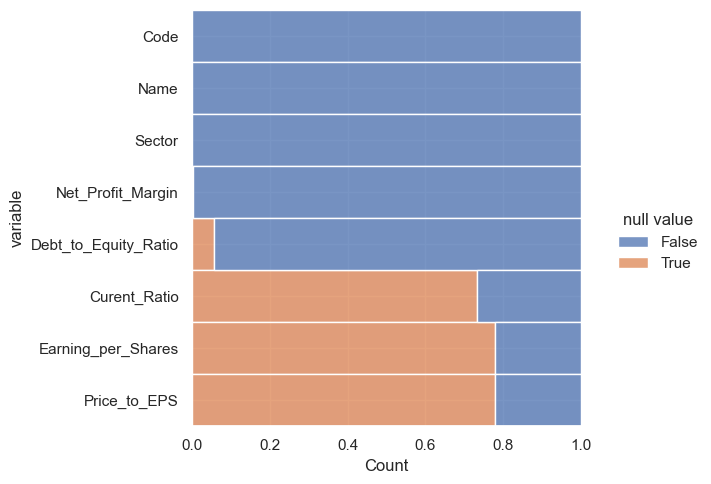

In [23]:
# copy data untuk menghindari perubahan yang tidak diinginkan
edaData = finalData.copy()

# plot proporsi null value
sns.displot(
    data=edaData.isna().melt(value_name="null value"),
    y="variable",
    hue="null value",
    multiple="fill",
    aspect=1.25
)


cek null value dari masing masing kolom

In [24]:
# cek null value dari masing masing kolom
nulltable = pd.DataFrame(edaData.isnull().sum().reset_index().iloc[1:])
nulltable.columns = ['financial statement', 'sum of null']
nulltable['% null'] = 100*(nulltable['sum of null']/len(edaData)).round(4)

print('total null: ', dataReshaped.isnull().sum().sum())
print(nulltable)

total null:  60673
    financial statement  sum of null  % null
1                  Name            0    0.00
2                Sector            0    0.00
3     Net_Profit_Margin            2    0.40
4  Debt_to_Equity_Ratio           29    5.77
5          Curent_Ratio          369   73.36
6    Earning_per_Shares          392   77.93
7          Price_to_EPS          392   77.93


periksa nilai infinit dan -infinit

In [25]:
# periksa nilai infinit dan -infinit
edaData.isin([np.inf, -np.inf]).sum()

Code                    0
Name                    0
Sector                  0
Net_Profit_Margin       3
Debt_to_Equity_Ratio    0
Curent_Ratio            0
Earning_per_Shares      0
Price_to_EPS            0
dtype: int64

buat fungsi untuk membuat boxplot dan histogram pada satu pallete untuk melihat distribusi data

In [26]:
# fungsi untuk membuat boxplot dan histogram pada satu pallete untuk melihat distribusi data

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    # buat dua baris plot
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # jumlah baris plot
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    # boxplot
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    ) 
    # histogram
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # menambahkan mean pada histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # menambahkan median pada histogram

filter kolom numerik saja

In [27]:
# filter hanya kolom bertipe numerik
numCols = edaData.select_dtypes(include=np.number).columns.tolist()

untuk setiap kolom numerik, lakukan plot distribusi data menggunakan histogram dan boxplot

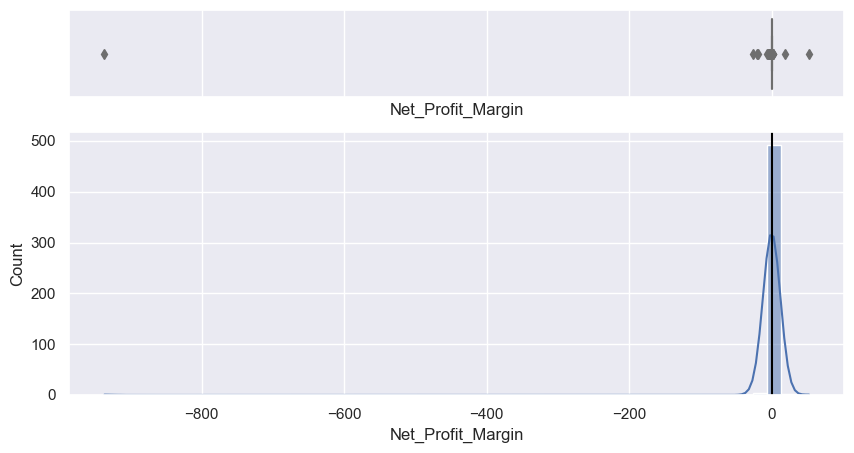

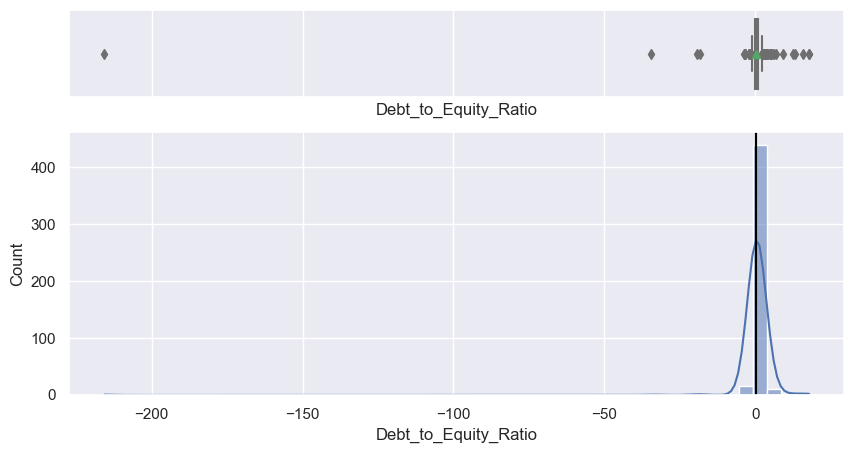

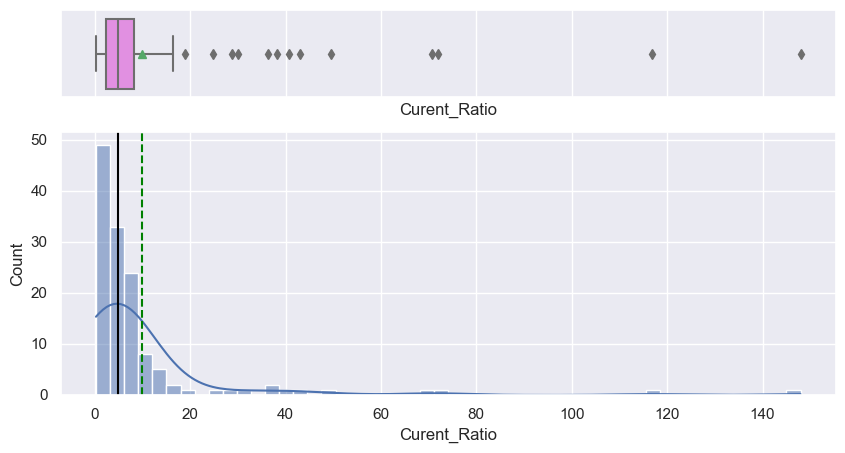

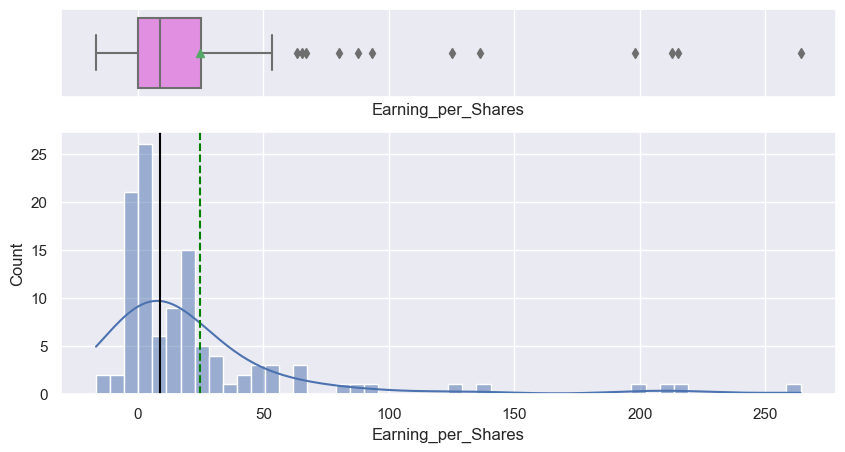

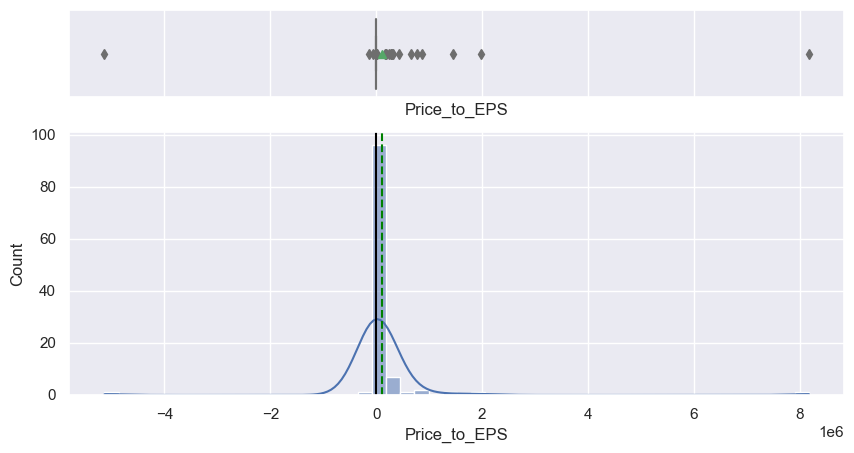

In [28]:
for col in numCols:
    histogram_boxplot(edaData, col, bins=50, kde=True, figsize=(10, 5))

fungsi untuk membuat barplot dengan label

In [29]:
# fungsi untuk membuat barplot dengan label

def labeled_barplot(data, feature, perc=False, n=None):

    total = len(data[feature]) 
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # persentase di setiap kategori
        else:
            label = p.get_height()  # jumlah tiap kategori

        x = p.get_x() + p.get_width() / 2 
        y = p.get_height() 

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        ) 

    plt.show() 

barplot proporsi tiap sektor 

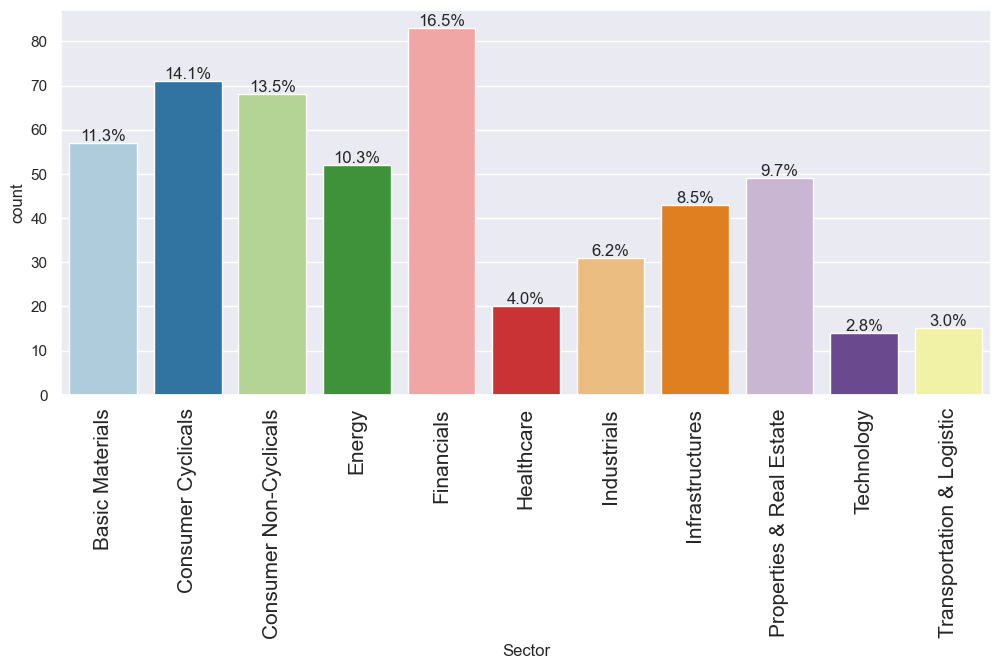

In [30]:
labeled_barplot(edaData, "Sector", perc=True)

plot NPM vs sektor

<Axes: xlabel='Sector', ylabel='Net_Profit_Margin'>

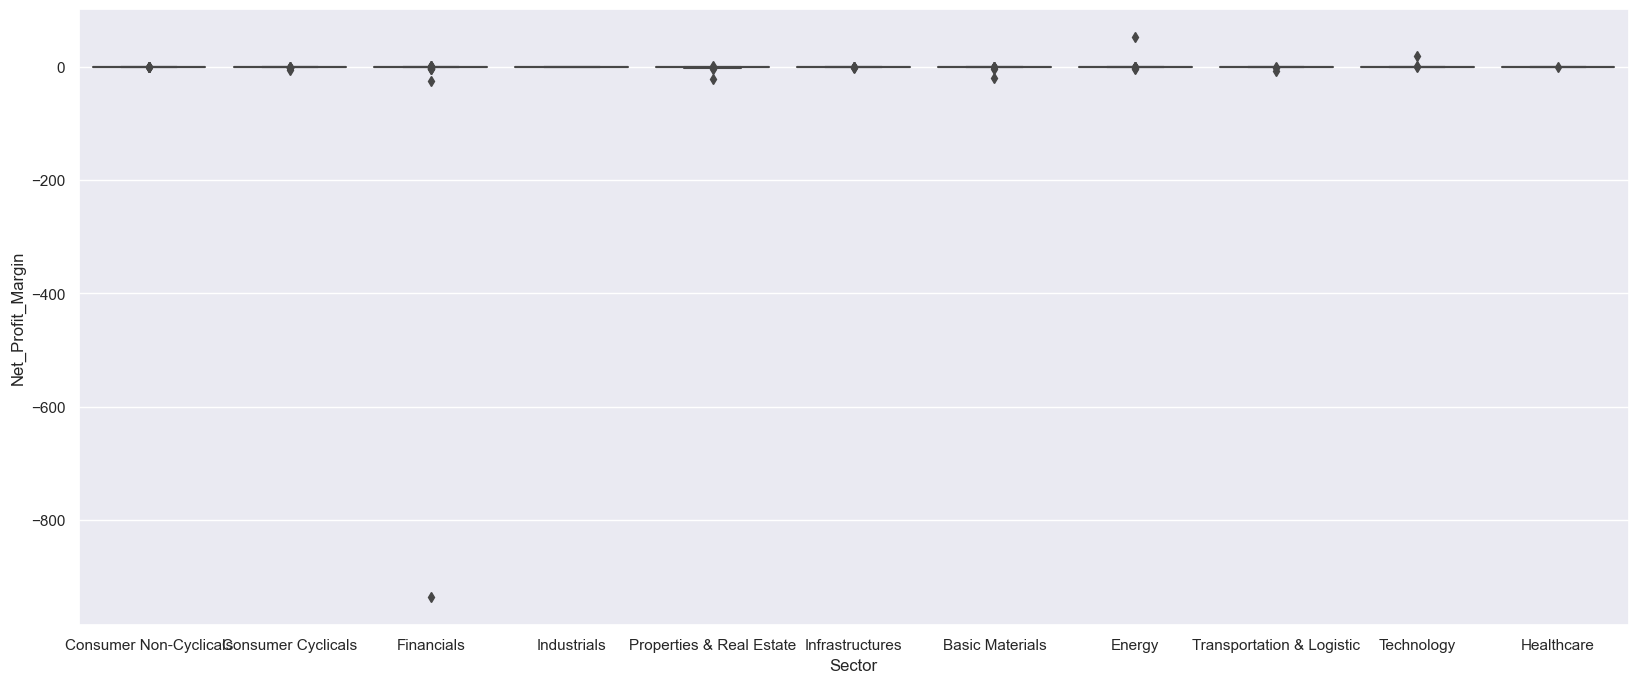

In [31]:
# plot NPM vs sektor
plt.figure(figsize=(20,8))
sns.boxplot(data = edaData, y = numCols[0], x = "Sector")

plot Debt to Equity vs sektor

<Axes: xlabel='Sector', ylabel='Debt_to_Equity_Ratio'>

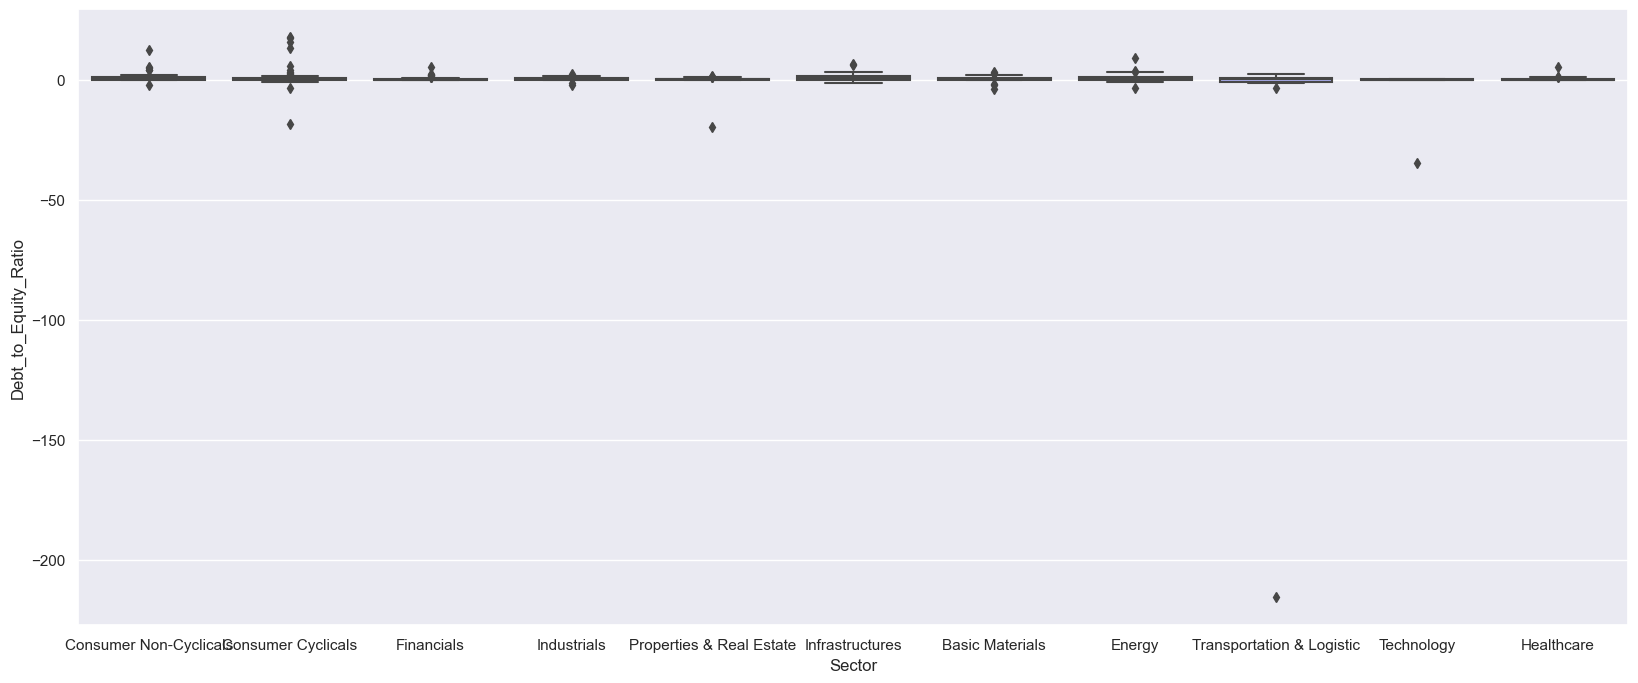

In [32]:
# plot Debt to Equity vs sektor
plt.figure(figsize=(20,8))
sns.boxplot(data = edaData, y = numCols[1], x = "Sector")

plot Current Ratio vs sektor

<Axes: xlabel='Sector', ylabel='Curent_Ratio'>

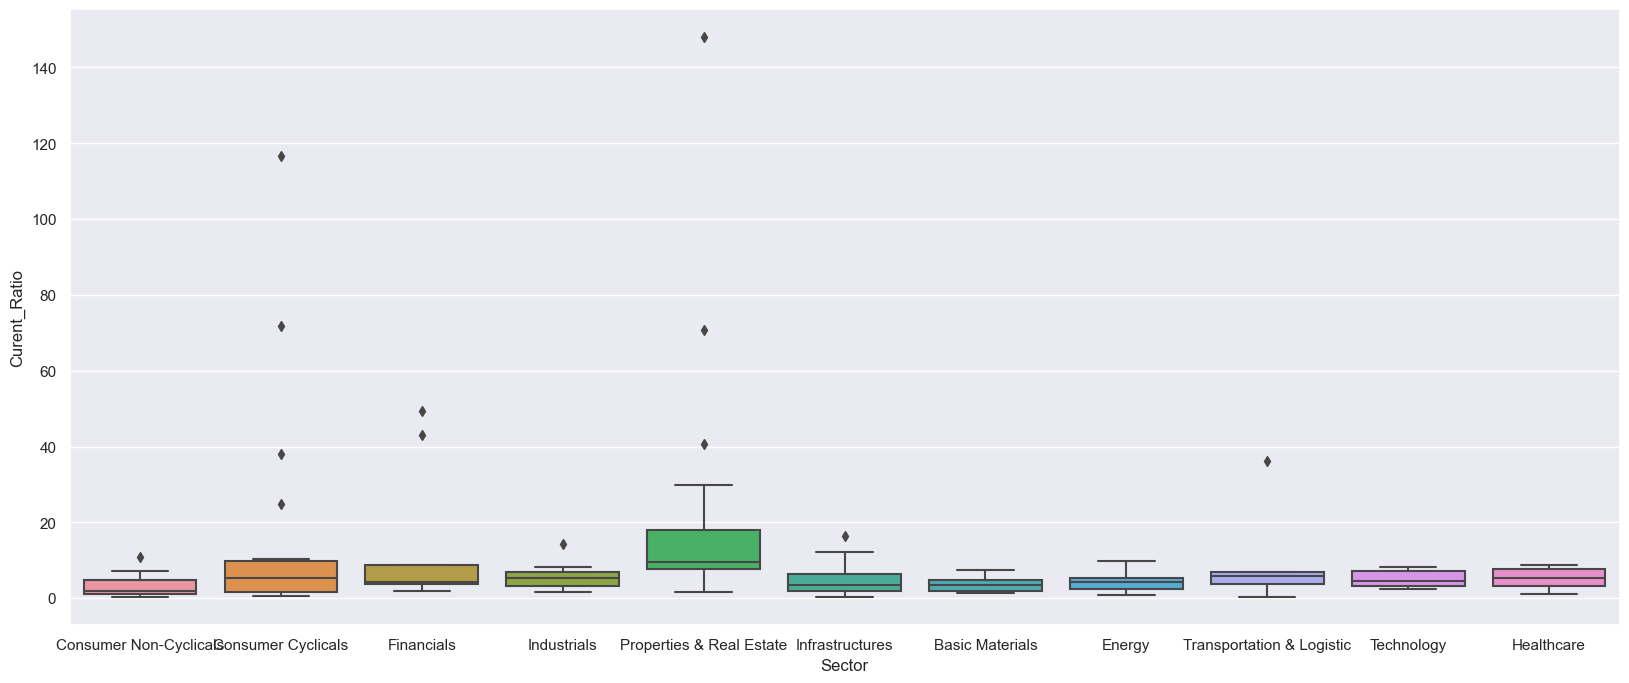

In [33]:
# plot Current Ratio vs sektor
plt.figure(figsize=(20,8))
sns.boxplot(data = edaData, y = numCols[2], x = "Sector")

plot EPS vs sektor

<Axes: xlabel='Sector', ylabel='Earning_per_Shares'>

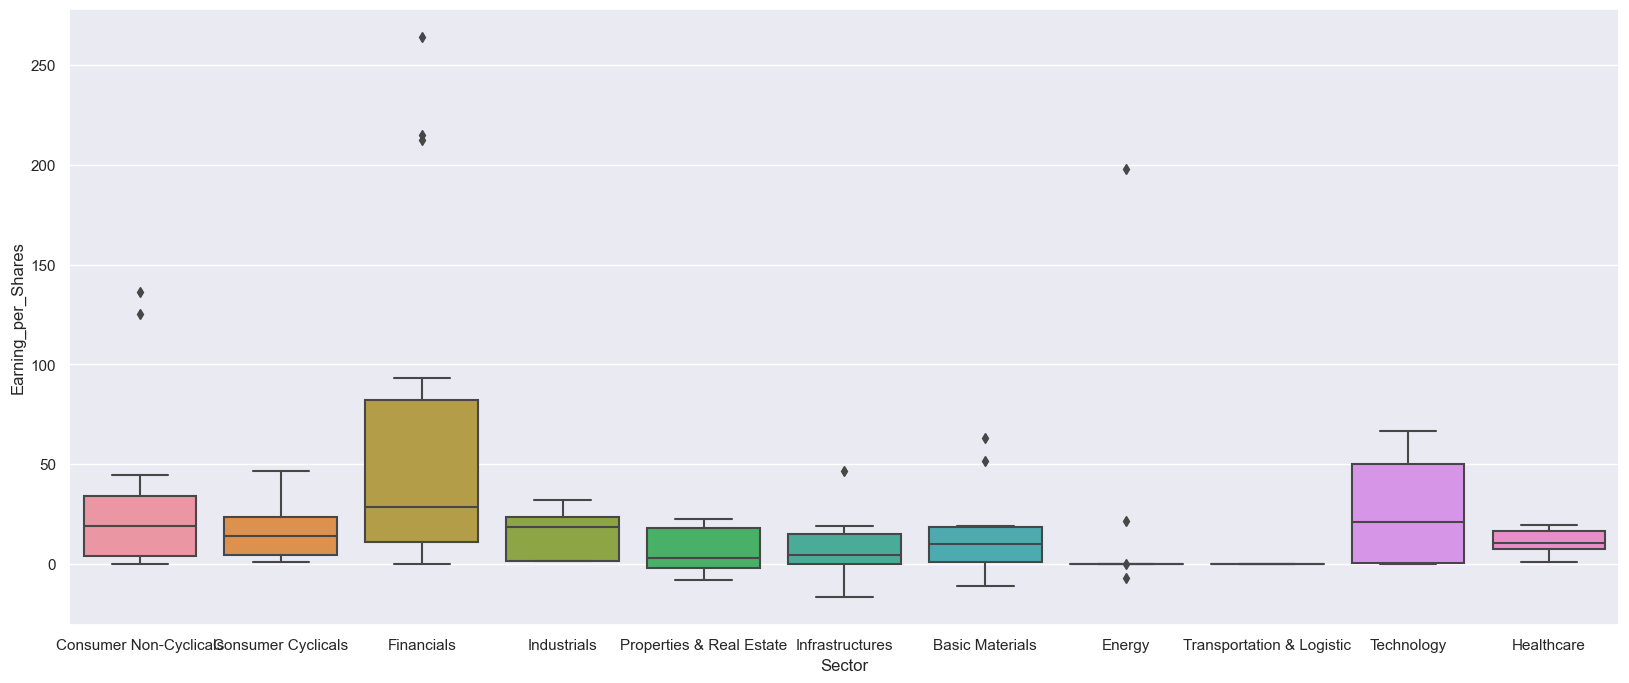

In [34]:
# plot EPS vs sektor
plt.figure(figsize=(20,8))
sns.boxplot(data = edaData, y = numCols[3], x = "Sector")

plot P\E vs sektor

<Axes: xlabel='Sector', ylabel='Price_to_EPS'>

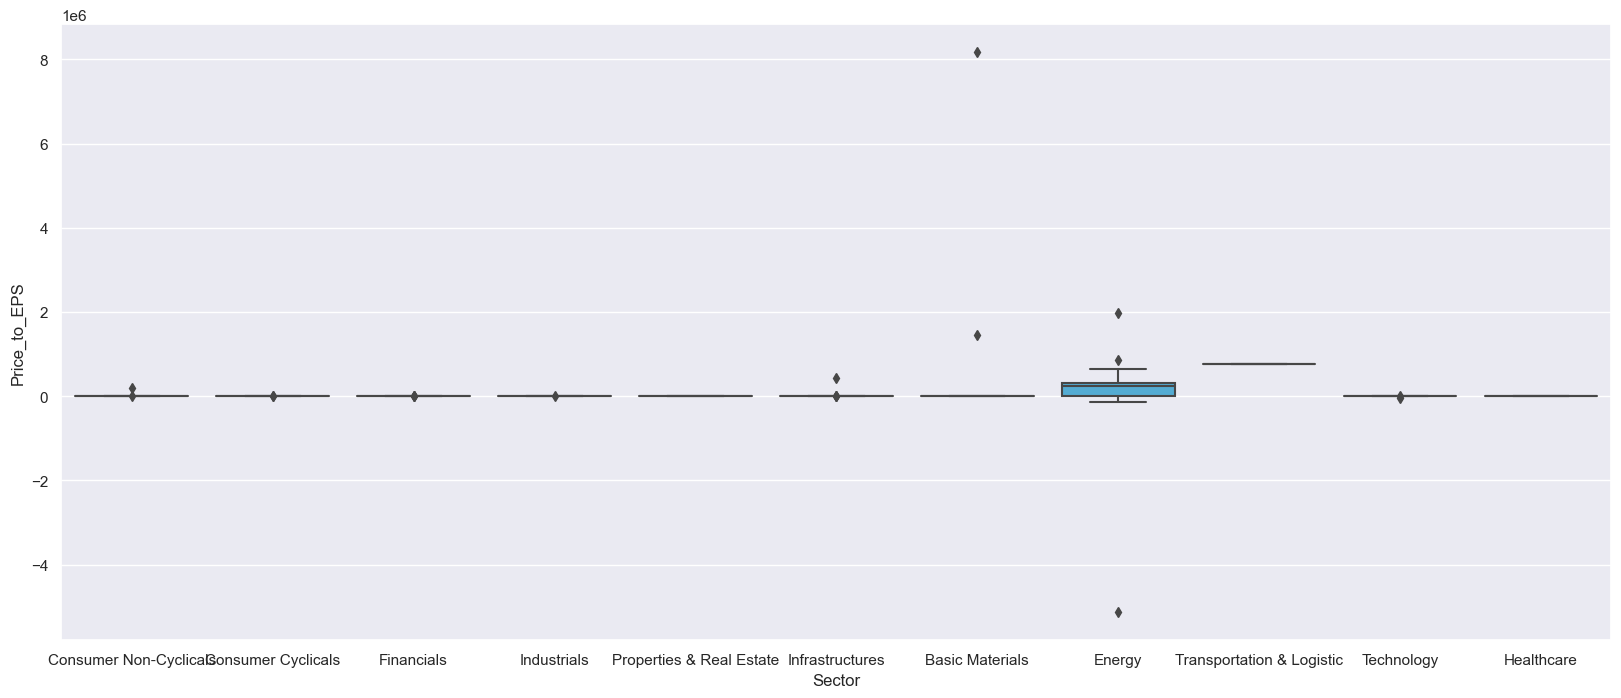

In [35]:
# plot P\E vs sektor
plt.figure(figsize=(20,8))
sns.boxplot(data = edaData, y = numCols[4], x = "Sector")

eksplorasi korelasi antar fitur/kolom dengan heatmap korelasi

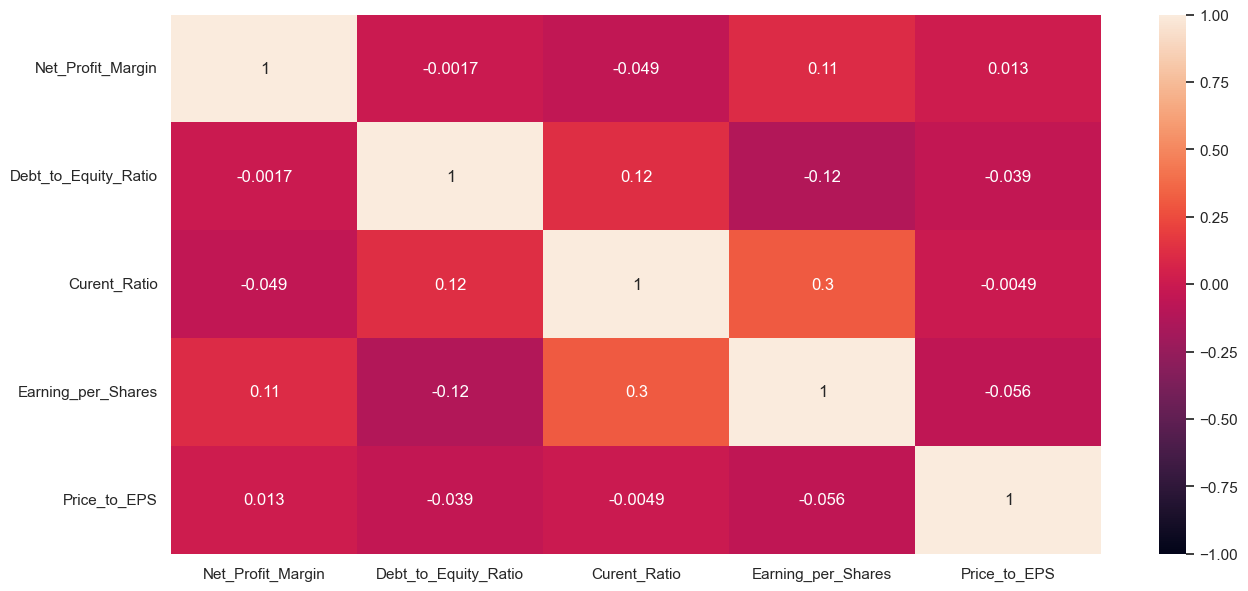

In [36]:
# melihat korelasi

plt.figure(figsize=(15, 7))
sns.heatmap(
    edaData[numCols].corr(), annot=True, vmin=-1, vmax=1
)
plt.show()

### 3.6. Imputasi Data
Imputasi menggunakan median.


In [37]:
imputedData = finalData.copy()

ganti nilai infinit dan -infinit dengan NaN

In [38]:
# ganti nilai infinit dan -infinit dengan NaN
imputedData['Net_Profit_Margin'] = imputedData['Net_Profit_Margin'].replace([np.inf, -np.inf], np.nan)

imputasi data dengan median

In [39]:
# imputasi data
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for col in numCols:
    newColName = 'Imputed_'+col
    imputedData[newColName] = imputer.fit_transform(imputedData[col].values.reshape(-1, 1))

pengecekan null value tiap fitur

In [40]:
imputedData.isnull().sum()

Code                              0
Name                              0
Sector                            0
Net_Profit_Margin                 5
Debt_to_Equity_Ratio             29
Curent_Ratio                    369
Earning_per_Shares              392
Price_to_EPS                    392
Imputed_Net_Profit_Margin         0
Imputed_Debt_to_Equity_Ratio      0
Imputed_Curent_Ratio              0
Imputed_Earning_per_Shares        0
Imputed_Price_to_EPS              0
dtype: int64

### 3.7. scaling data

untuk scaling data, digunakan min max scaler

In [41]:
scaledData = imputedData.copy()

scaler = MinMaxScaler()

# ambil hanya kolom bertipe numerik
imputedNumCols = imputedData.select_dtypes(include=np.number).columns.tolist()

for col in imputedNumCols:
    newColName = 'Scaled_'+col
    scaledData[newColName] = scaler.fit_transform(imputedData[col].values.reshape(-1, 1))

5 data teratas hasil scaling

In [42]:
scaledData.head()

,Code,Name,Sector,Net_Profit_Margin,Debt_to_Equity_Ratio,Curent_Ratio,Earning_per_Shares,Price_to_EPS,Imputed_Net_Profit_Margin,Imputed_Debt_to_Equity_Ratio,...,Scaled_Net_Profit_Margin,Scaled_Debt_to_Equity_Ratio,Scaled_Curent_Ratio,Scaled_Earning_per_Shares,Scaled_Price_to_EPS,Scaled_Imputed_Net_Profit_Margin,Scaled_Imputed_Debt_to_Equity_Ratio,Scaled_Imputed_Curent_Ratio,Scaled_Imputed_Earning_per_Shares,Scaled_Imputed_Price_to_EPS
0,AALI,Astra Agro Lestari Tbk.,Consumer Non-Cyclicals,0.073458,0.271142,NaN,NaN,NaN,0.073458,0.271142,...,0.947101,0.924804,NaN,NaN,NaN,0.947101,0.924804,0.031201,0.091423,0.385785
1,ABBA,Mahaka Media Tbk.,Consumer Cyclicals,-0.285803,0.320820,8.817620,NaN,NaN,-0.285803,0.320820,...,0.946738,0.925017,0.057986,NaN,NaN,0.946738,0.925017,0.057986,0.091423,0.385785
2,ABDA,Asuransi Bina Dana Arta Tbk.,Financials,0.246463,NaN,49.460100,NaN,NaN,0.246463,0.311725,...,0.947276,NaN,0.333118,NaN,NaN,0.947276,0.924978,0.333118,0.091423,0.385785
3,ABMM,ABM Investama Tbk.,Industrials,0.110880,1.150920,3.560481,NaN,NaN,0.110880,1.150920,...,0.947139,0.928573,0.022397,NaN,NaN,0.947139,0.928573,0.022397,0.091423,0.385785
4,ACES,Ace Hardware Indonesia Tbk.,Consumer Cyclicals,0.094373,0.138336,NaN,8.965835,54.651906,0.094373,0.138336,...,0.947122,0.924235,NaN,0.091423,0.385785,0.947122,0.924235,0.031201,0.091423,0.385785


# 4. modelling
pada tahap ini dilakukan pembangunan cluster dengan beberapa algoritma, yaitu:
- K-means
- GMM 
- DBSCAN

In [167]:
# persiapkan data untuk masing masing skenario
numFinalCols = scaledData.select_dtypes(include=np.number).columns.tolist()
kMeansData = scaledData[[col for col in numFinalCols if 'Scaled_Imputed' in col]]
gmmData = kMeansData.copy()
dbscanData = kMeansData.copy()

### 4.1. Model tanpa tuning

#### 4.1.1. Kmeans

pembangunan klaster dengan algoritma K-Means sebanyak 5 klaster

In [174]:
# pembangunan klaster dengan algoritma K-Means sebanyak 5 klaster
kmeans = KMeans(n_clusters=5)
kmeans.fit(kMeansData)
kmeansLabels = kmeans.labels_
kMeansData['K_means_segments'] = kmeansLabels

reduksi dimensi data menjadi dua dimensi untuk keperluan visualisasi hasil klasterisasi

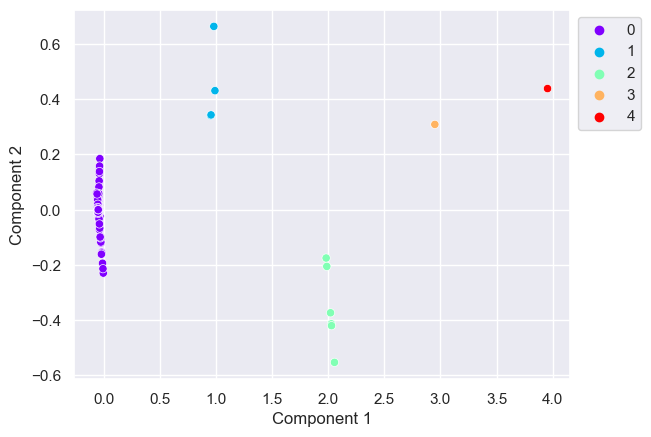

In [175]:
# reduksi dimensi data menjadi dua dimensi untuk keperluan visualisasi hasil klasterisasi
pca = PCA(n_components=2)

# transforming data and storing results in a dataframe
XReducedPCA = pca.fit_transform(kMeansData)
reducedDfPCA = pd.DataFrame(
    data=XReducedPCA, columns=["Component 1", "Component 2"]
)

sns.scatterplot(
    data=reducedDfPCA,
    x="Component 1",
    y="Component 2",
    hue=kMeansData["K_means_segments"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

### 4.1.2 Gaussian Mixture Models

pembangunan klaster dengan algoritma GMM dengan banyak komponen sebanyak 5

In [176]:
# GMM
gmmModel = GaussianMixture(n_components=5)
gmmModel.fit(gmmData)
yhat = gmmModel.predict(gmmData)
gmmLabels = yhat
gmmData['GMM_segments'] = yhat


reduksi dimensi data menjadi dua dimensi dan plot menggunakan scatterplot

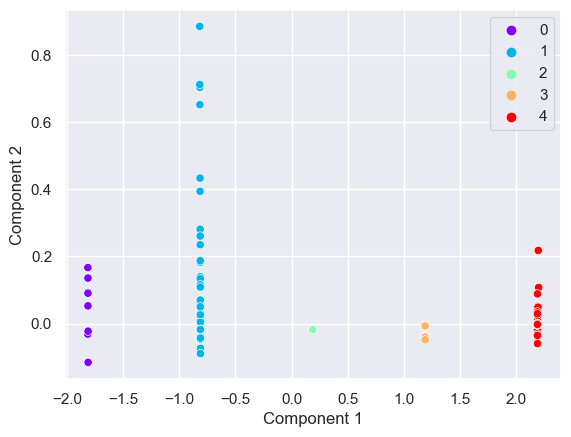

In [177]:
# transforming data and storing results in a dataframe

XReducedPCA = pca.fit_transform(gmmData)
reducedDfPCA = pd.DataFrame(
    data=XReducedPCA, columns=["Component 1", "Component 2"]
)

sns.scatterplot(
    data=reducedDfPCA,
    x="Component 1",
    y="Component 2",
    hue=gmmData["GMM_segments"],
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

#### 4.1.3. DBSCAN

pembangunan model DBSCAN dengan hyperparameter default (eps=5, min_sample=5) lalu dilanjutkan dengan reduksi dimensi dan plot klaster

explained variance:  0.012304695144598327


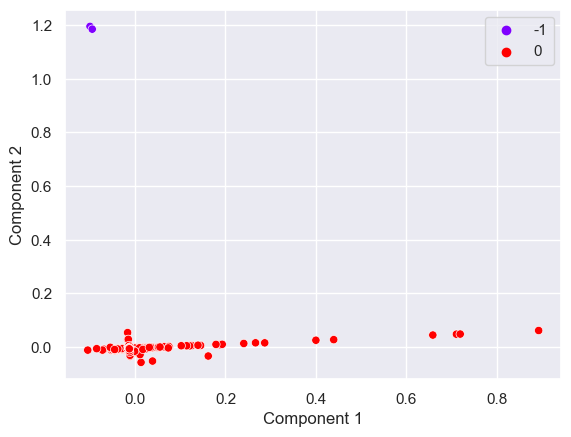

In [178]:
# DBSCAN

dbscanModel = DBSCAN()
dbscanModel.fit(dbscanData)
yhat = dbscanModel.fit_predict(dbscanData)
dbscanLabels = yhat
dbscanData['DBSCAN_segments'] = yhat

XReducedPCA = pca.fit_transform(dbscanData)
reducedDfPCA = pd.DataFrame(
    data=XReducedPCA, columns=["Component 1", "Component 2"]
)
print('explained variance: ', pca.explained_variance_.sum())
sns.scatterplot(
    data=reducedDfPCA,
    x="Component 1",
    y="Component 2",
    hue=dbscanData['DBSCAN_segments'] ,
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

evaluasi model tanpa tuning menggunkana skor silhouette, calinski-harabasz index, dan davies-bouldin index

In [179]:
alg = ['KMeans', 'GMM', 'DBSCAN']
silhouetteScores = [silhouette_score(kMeansData, kmeansLabels), silhouette_score(gmmData, gmmLabels), silhouette_score(dbscanData, dbscanLabels)]
calinskiHarabaszIndex = [calinski_harabasz_score(kMeansData, kmeansLabels), calinski_harabasz_score(gmmData, gmmLabels), calinski_harabasz_score(dbscanData, dbscanLabels)]
DaviesBouldinIndex= [davies_bouldin_score(kMeansData, kmeansLabels), davies_bouldin_score(gmmData, gmmLabels), davies_bouldin_score(dbscanData, dbscanLabels)]

evaluationDf = pd.DataFrame({
    "algoritma":alg,
    "Silhouette Score":silhouetteScores,
    "Calinski-Harabasz Index":calinskiHarabaszIndex,
    "Davies-Bouldin Index":DaviesBouldinIndex
})
evaluationDf

,algoritma,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,KMeans,0.956606,3423.564575,0.183594
1,GMM,0.935965,16402.695119,0.154642
2,DBSCAN,0.948211,200.701770,0.589859


### 4.2. Hyperparameter Tuning

#### 4.2.1 Tuning K-Means

mencari jumlah klaster terbaik dengan skor silhouette terbaik

In [180]:
# mencari jumlah klaster terbaik dengan nilai silhouette terbaik
sil_score = []
# jumlah klaster dari 2 hingga 14
kMeansData = kMeansData.loc[:, kMeansData.columns != 'K_means_segments']
cluster_list = list(range(2,15))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((kMeansData))
    score = silhouette_score(kMeansData, preds)
    sil_score.append(score)
    print("untuk jumlah klaster = {}, skor silhouette {})".format(n_clusters, score))

untuk jumlah klaster = 2, skor silhouette 0.9058471087340073)
untuk jumlah klaster = 3, skor silhouette 0.9108156334368226)
untuk jumlah klaster = 4, skor silhouette 0.9132447983306079)
untuk jumlah klaster = 5, skor silhouette 0.9156068373347589)
untuk jumlah klaster = 6, skor silhouette 0.8283398977733396)
untuk jumlah klaster = 7, skor silhouette 0.843111837685758)
untuk jumlah klaster = 8, skor silhouette 0.8481621136943885)
untuk jumlah klaster = 9, skor silhouette 0.8510666501429459)
untuk jumlah klaster = 10, skor silhouette 0.7836718005307096)
untuk jumlah klaster = 11, skor silhouette 0.7857666255930088)
untuk jumlah klaster = 12, skor silhouette 0.5988788664698911)
untuk jumlah klaster = 13, skor silhouette 0.6018038919936333)
untuk jumlah klaster = 14, skor silhouette 0.61701521567532)


plot skor silhouette

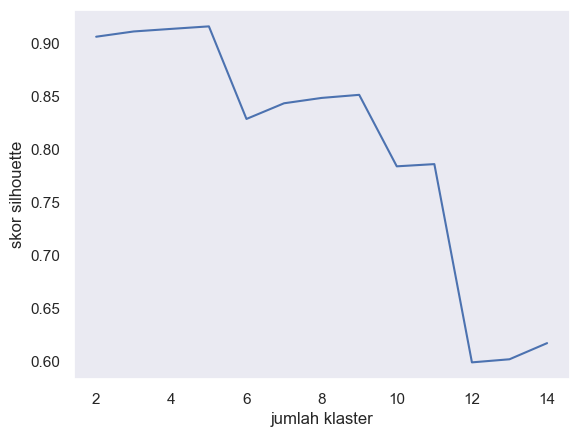

In [181]:
plt.plot(cluster_list,sil_score)
plt.xlabel('jumlah klaster')
plt.ylabel('skor silhouette')
plt.grid()

berdasarkan visualisasi skor silhouette vs jumlah klaster, jumlah klaster terbaik ialah 5. skor silhouette terbaik dilihat dari skor silhouette yang paling besar. semakin besar skor silhouette, semakin baik klaster yang dibentuk (jarak intra klaster semakin kecil, inter klaster semakin besar).

#### 4.2.2. Tuning GMM

Dilakukan dengan melihat skor Bayes Information Criterion, yang dipilih ialah skor BIC terendah.

In [182]:
gmmData = gmmData.loc[:, gmmData.columns !='GMM_segments']

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 15),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(gmmData)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 15)},
             scoring=<function gmm_bic_score at 0x000001901C14E5E0>)

tampilkan skor BIC untuk setiap kombinasi banyak komponen dan tipe varians

In [183]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
6,7,spherical,-3543.070334
7,8,spherical,-3535.113480
4,5,spherical,-3520.730533
8,9,spherical,-3474.828378
5,6,spherical,-3474.385560


karena skor BIC minimum berada pada kombinasi tipe varians spherical dan banyak komponen 7, maka dua kombinasi hyperparameter itu yang akan dipakai untuk model GMM akhir

tampilkan barplot untuk setiap kombinasi, terlihat bahwa tipe kovarians tied paling buruk di kasus ini, dan tipe spherical merupakan yang paling baik.

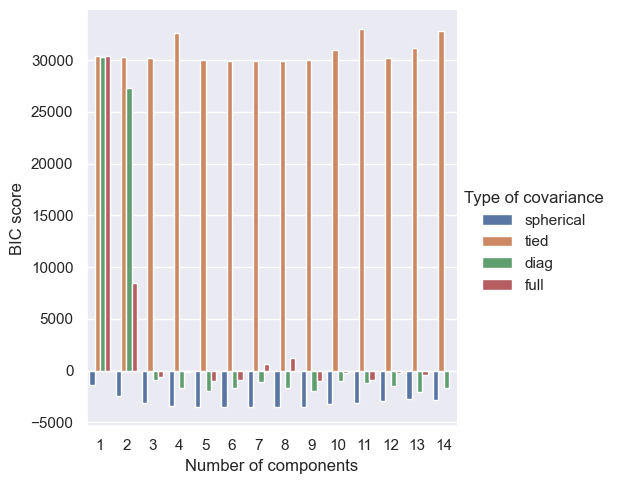

In [184]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

#### 4.2.3. Tuning DBSCAN

Terdapat dua parameter yang perlu ditune di algoritma DBSCAN, yaitu epsilon dan sampel minimum.
menurut Sander et al., 1998, sampel minimum yang paling optimal ialah 2 kali dimensi data. kita memiliki 5 feature, sehingga sampel minimum optimal yaitu 10 sampel.
sementara epsilon terbaik bisa dilihat dari grafik elbow dari epsilon vs jarak antar data.

In [185]:
# drop kolom klaster sebelumnya
dbscanData = dbscanData.loc[:, dbscanData.columns !='DBSCAN_segments']
minSample = 2*len(dbscanData.columns)
# hitung jarak menggunakan algoritma nearest neighbors
nn = NearestNeighbors(n_neighbors=minSample).fit(dbscanData)
distances, indices = nn.kneighbors(dbscanData)

tampilkan plot epsilon dan jarak.

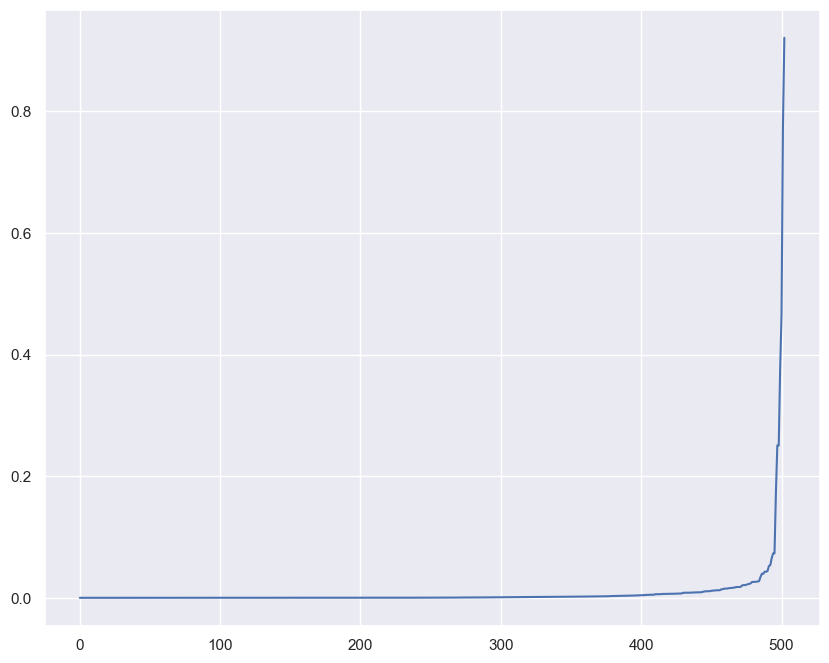

In [186]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

epsilon terbaik berada di sekitar 0.0 hingga 0.2 (daerah yang membentuk siku, paper Determination of Optimal Epsilon (Eps) Value on
DBSCAN Algorithm to Clustering Data on
Peatland Hotspots in Sumatra).
dilakukan perhitungan skor silouette untuk setiap epsilon yang berada di rentang tersebut dengan iterasi epsilon 0.01

In [187]:
# pencarian skor silhouette terbaik

sil_score = []
epsList = np.arange(0.01, 0.2, 0.01)

for eps in epsList:
    clusterer = DBSCAN(eps=eps, min_samples=minSample)
    preds = clusterer.fit_predict((dbscanData))
    score = silhouette_score(dbscanData, preds)
    sil_score.append(score)
    print("untuk epsilon = {}, skor silhouette {})".format(eps, score))

untuk epsilon = 0.01, skor silhouette 0.44689740767624586)
untuk epsilon = 0.02, skor silhouette 0.7601523614706187)
untuk epsilon = 0.03, skor silhouette 0.8131937959532509)
untuk epsilon = 0.04, skor silhouette 0.8357213750729883)
untuk epsilon = 0.05, skor silhouette 0.8559364083322266)
untuk epsilon = 0.060000000000000005, skor silhouette 0.8629450664937884)
untuk epsilon = 0.06999999999999999, skor silhouette 0.8749278158891591)
untuk epsilon = 0.08, skor silhouette 0.8857151230502178)
untuk epsilon = 0.09, skor silhouette 0.8930814475114015)
untuk epsilon = 0.09999999999999999, skor silhouette 0.9053752840835214)
untuk epsilon = 0.11, skor silhouette 0.9053752840835214)
untuk epsilon = 0.12, skor silhouette 0.9053752840835214)
untuk epsilon = 0.13, skor silhouette 0.9053752840835214)
untuk epsilon = 0.14, skor silhouette 0.91006140210358)
untuk epsilon = 0.15000000000000002, skor silhouette 0.91006140210358)
untuk epsilon = 0.16, skor silhouette 0.9115004974976149)
untuk epsilon 

skor silhouette

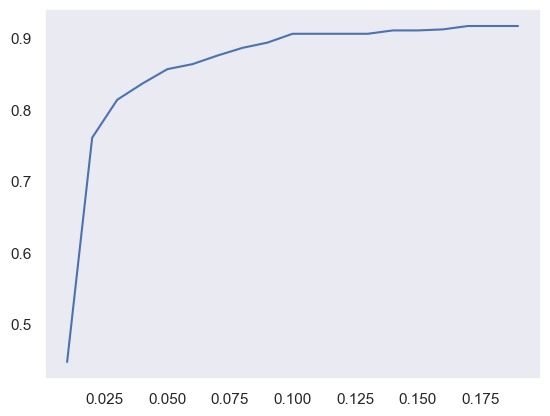

In [188]:
# skor silhouette
plt.plot(epsList,sil_score)
plt.grid()

epsilon terbaik ialah yang menghasilkan skor silhouette tertinggi. Terlihat dari grafik bahwa pada epsilon 0.175 dan seterusnya tidak terjadi peningkatan signifikan, sehingga epsilon yang digunakan ialah 0.175

#### 4.3 Modeling dengan Hyperparameter Hasil Tuning

Tuned Kmeans

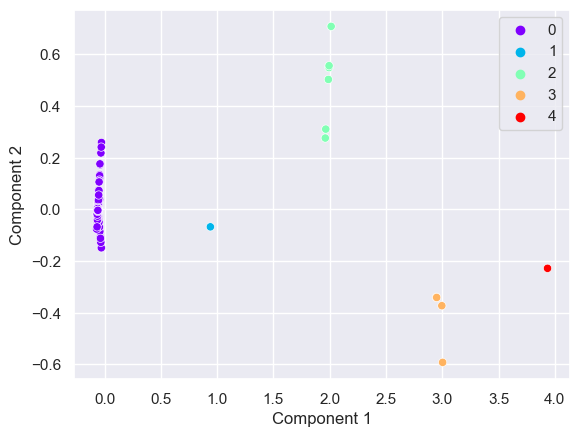

In [195]:
# Tuned Kmeans
kMeansData = kMeansData.loc[:, kMeansData.columns != 'K_means_segments']
kmeansTuned = KMeans(n_clusters=5)
kmeansTuned.fit(kMeansData)
kmeansLabels = kmeansTuned.labels_
kMeansData['K_means_tuned_segments'] = kmeansLabels

XReducedPCA = pca.fit_transform(kMeansData)
reducedDfPCA = pd.DataFrame(
    data=XReducedPCA, columns=["Component 1", "Component 2"]
)
sns.scatterplot(
    data=reducedDfPCA,
    x="Component 1",
    y="Component 2",
    hue=kMeansData['K_means_tuned_segments'] ,
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))


Tuned GMM 

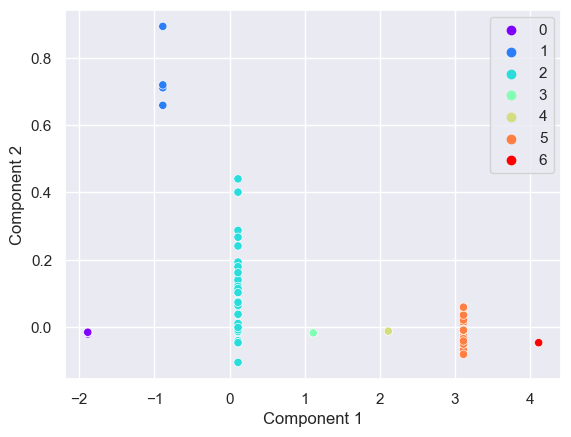

In [190]:
# Tuned GMM 
gmmData = gmmData.loc[:, gmmData.columns != 'GMM_segments']
gmmTuned = GaussianMixture(n_components=7, covariance_type='spherical')
gmmTuned.fit(gmmData)
gmmLabels = gmmTuned.predict(gmmData)
gmmData['GMM_tuned_segments'] = gmmLabels

XReducedPCA = pca.fit_transform(gmmData)
reducedDfPCA = pd.DataFrame(
    data=XReducedPCA, columns=["Component 1", "Component 2"]
)
sns.scatterplot(
    data=reducedDfPCA,
    x="Component 1",
    y="Component 2",
    hue=gmmData['GMM_tuned_segments'] ,
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

Tuned DBSCAN

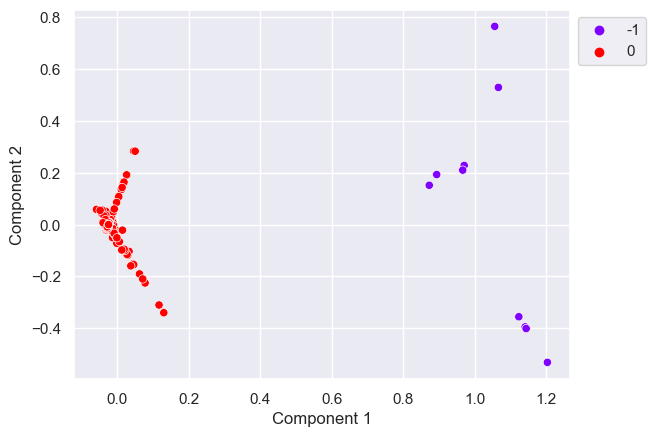

In [191]:
#  Tuned DBSCAN
dbscanData = dbscanData.loc[:, dbscanData.columns !='DBSCAN_segments']
dbscanModel = DBSCAN(eps=0.175, min_samples=minSample)
dbscanModel.fit(dbscanData)
dbscanLabels = dbscanModel.fit_predict(dbscanData)
dbscanData['DBSCAN_tuned_segments'] = dbscanLabels
XReducedPCA = pca.fit_transform(dbscanData)
reducedDfPCA = pd.DataFrame(
    data=XReducedPCA, columns=["Component 1", "Component 2"]
)
sns.scatterplot(
    data=reducedDfPCA,
    x="Component 1",
    y="Component 2",
    hue=dbscanData['DBSCAN_tuned_segments'] ,
    palette="rainbow",
)
plt.legend(bbox_to_anchor=(1, 1))

# 5. Evaluasi
evaluasi klaster dilakukan menggunakan :
- Silhouette Score
- Calinski-Harabasz Index
- Davies-Bouldin Index

In [192]:
alg = ['KMeans', 'GMM', 'DBSCAN']
silhouetteScores = [silhouette_score(kMeansData, kmeansLabels), silhouette_score(gmmData, gmmLabels), silhouette_score(dbscanData, dbscanLabels)]
calinskiHarabaszIndex = [calinski_harabasz_score(kMeansData, kmeansLabels), calinski_harabasz_score(gmmData, gmmLabels), calinski_harabasz_score(dbscanData, dbscanLabels)]
DaviesBouldinIndex= [davies_bouldin_score(kMeansData, kmeansLabels), davies_bouldin_score(gmmData, gmmLabels), davies_bouldin_score(dbscanData, dbscanLabels)]

evaluationDf = pd.DataFrame({
    "algoritma":alg,
    "Silhouette Score":silhouetteScores,
    "Calinski-Harabasz Index":calinskiHarabaszIndex,
    "Davies-Bouldin Index":DaviesBouldinIndex
})
evaluationDf

,algoritma,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,KMeans,0.956245,3078.997508,0.186129
1,GMM,0.960808,76911.771937,0.133063
2,DBSCAN,0.949079,837.247205,0.650169


tambahkan label pada data awal

In [198]:
finalData['cluster'] = gmmData['GMM_tuned_segments']

5 number summary perklaster

In [201]:
finalData.groupby('cluster').describe()

Net_Profit_Margin                                                \
                    count        mean       std         min         25%   
cluster                                                                   
0                   283.0        -inf       NaN        -inf    0.004141   
1                     4.0    0.443280  0.294188    0.269950    0.275473   
2                    41.0         inf       NaN   -3.512454    0.021839   
3                     1.0 -936.275271       NaN -936.275271 -936.275271   
4                     1.0    0.099212       NaN    0.099212    0.099212   
5                   170.0    0.015363  5.193569  -25.647890    0.000671   
6                     1.0    0.011497       NaN    0.011497    0.011497   

                                            Debt_to_Equity_Ratio              \
                50%         75%         max                count        mean   
cluster                                                                        
0          0.063065    0.177086    2.094678                264.0    0.435824   
1          0.310730    0.478537    0.881713                  4.0    0.241555   
2          0.083320    0.268035         inf                 38.0   -0.987447   
3       -936.275271 -936.275271 -936.275271                  0.0         NaN   
4          0.099212    0.099212    0.099212                  1.0 -215.611954   
5          0.045433    0.129799   52.371828                166.0    1.283006   
6          0.011497    0.011497    0.011497                  1.0    1.984160   

         ... Earning_per_Shares             Price_to_EPS                \
         ...                75%         max        count          mean   
cluster  ...                                                             
0        ...           7.717940    8.965835          5.0  1.053163e+02   
1        ...         227.345207  264.007387          4.0  2.841079e+01   
2        ...          65.500571  136.304851         25.0 -6.795153e+04   
3        ...                NaN         NaN          0.0           NaN   
4        ...                NaN         NaN          0.0           NaN   
5        ...          17.063993   28.069060         76.0  5.924369e+04   
6        ...           0.000100    0.000100          1.0  8.170815e+06   

                                                                               \
                  std           min           25%           50%           75%   
cluster                                                                         
0        8.193620e+01  3.778861e+01  4.898794e+01  5.465191e+01  1.668306e+02   
1        1.803986e+01  8.939144e+00  1.522193e+01  2.957449e+01  4.276335e+01   
2        1.159330e+06 -5.131950e+06  1.548953e+01  2.711343e+01  5.754221e+01   
3                 NaN           NaN           NaN           NaN           NaN   
4                 NaN           NaN           NaN           NaN           NaN   
5        1.716905e+05 -1.466388e+05  2.663708e+01  8.761676e+01  4.050131e+02   
6                 NaN  8.170815e+06  8.170815e+06  8.170815e+06  8.170815e+06   

                       
                  max  
cluster                
0        2.183225e+02  
1        4.555502e+01  
2        1.986173e+06  
3                 NaN  
4                 NaN  
5        8.584105e+05  
6        8.170815e+06  

[7 rows x 40 columns]

Contoh kasus : ambil saham BBRI, kembalikan saham-saham yang mirip dengan saham tersebut.

In [218]:
clusterBBRI = finalData.loc[finalData['Code']=='BBRI']['cluster'].values[0]
print('BBRI ada di klaster', clusterBBRI)
sameClusterAsBBRI = finalData.loc[finalData['cluster']==clusterBBRI]
print('banyak saham yang satu klaster dengan BBRI :', len(sameClusterAsBBRI))
sameClusterAsBBRI


BBRI ada di klaster 2
banyak saham yang satu klaster dengan BBRI : 41


,Code,Name,Sector,Net_Profit_Margin,Debt_to_Equity_Ratio,Curent_Ratio,Earning_per_Shares,Price_to_EPS,cluster
2,ABDA,Asuransi Bina Dana Arta Tbk.,Financials,0.246463,NaN,49.460100,NaN,NaN,2
45,ATIC,Anabatic Technologies Tbk.,Technology,0.053360,-34.687094,NaN,NaN,NaN,2
59,BBMD,Bank Mestika Dharma Tbk.,Financials,0.452411,NaN,NaN,29.944701,6.912742e+01,2
61,BBRI,Bank Rakyat Indonesia (Persero,Financials,0.293095,0.439481,NaN,80.288884,5.754221e+01,2
72,BEST,Bekasi Fajar Industrial Estate,Properties & Real Estate,0.179828,0.357705,40.744249,NaN,NaN,2
80,BIRD,Blue Bird Tbk.,Transportation & Logistic,0.069947,0.159054,36.275370,NaN,NaN,2
96,BNGA,Bank CIMB Niaga Tbk.,Financials,0.248777,0.235669,NaN,47.890228,2.390884e+01,2
103,BPII,Batavia Prosperindo Internasio,Financials,0.137846,0.968461,NaN,65.500571,1.633574e+02,2
114,BTPN,Bank BTPN Tbk.,Financials,0.237065,1.125387,NaN,93.311681,2.711343e+01,2
115,BTPS,Bank BTPN Syariah Tbk.,Financials,0.349440,0.023409,NaN,53.359510,4.910090e+01,2
